In [1]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import time
import rebound
import xgboost as xgb
import sklearn
import os
from sklearn.model_selection import cross_val_score

from sklearn import metrics

/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Check if the feature importances change for short integrations vs longterm integrations


In [3]:
data_list = pd.read_csv("../csvs/BetaFeats/sifOrbsMore=10000.0Nout=100window=10.csv", index_col = 0)

features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 



data_list.head()

,runstring,t_final_short,Rel_Eerr_short,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,...,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,wall_time,Stable,instability_time,Rel_Eerr
0,0000000.bin,10000.0,1.346025e-08,8.488064,0.048209,8.344623,8.551727,15.791595,0.085995,15.576612,...,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,0.395531,0.0,1.235644e+07,1.099985e-04
1,0000001.bin,10000.0,8.934681e-10,8.414875,0.039142,8.308582,8.495900,15.314101,0.037065,15.254833,...,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,0.403877,0.0,1.348749e+05,1.388587e-08
2,0000002.bin,10000.0,3.169983e-08,3.566625,0.132349,3.331239,3.773868,25.113282,0.137779,24.898424,...,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,0.397334,0.0,1.276381e+04,3.048261e-04
3,0000003.bin,10000.0,6.097589e-10,18.513867,0.003597,18.498104,18.521611,19.142029,0.008997,19.120348,...,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,0.391764,1.0,1.000000e+09,6.492574e-10
4,0000004.bin,10000.0,5.951220e-03,23.314674,6.756316,3.957209,38.942908,-19.036068,5.544896,-21.930247,...,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,0.402905,0.0,8.791888e+01,9.336734e-07


In [3]:
def plot_feats_imps(model):
    feats = pd.Series(model.booster().get_fscore()).sort_values(ascending = False)
    total_imp = np.sum(feats)
    feats = feats/float(total_imp)
    feats.plot(kind = "bar", title = "Feature Importances", figsize = (12, 8))
    plt.ylabel("Normalized Importance")
    return feats

In [4]:
#{'x_min_child': 4.0, 'x_tree_colsample': 0.7452992521028268,
#'x_max_depth': 7.0, 'x_subsample': 0.938790987639708, 'x_learning_rate': 0.08584312332127479}

min_child_w = 4
n_est=100
max_d = 7
learning_r = 0.085
subsample = 0.94
weight = 2

model = xgb.XGBClassifier(min_child_weight=min_child_w, n_estimators=n_est, max_depth=max_d, learning_rate=learning_r, scale_pos_weight=weight, subsample=subsample)


In [4]:
best = {'x_learning_rate': 0.16789058169707416,
 'x_max_depth': 13,
 'x_min_child': 7.0,
 'x_pos_weight': 6.606175001822464,
 'x_subsample': 0.9872987553651339,
 'x_tree_colsample': 0.7158073319959313}
best

{'x_learning_rate': 0.16789058169707416,
 'x_max_depth': 13,
 'x_min_child': 7.0,
 'x_pos_weight': 6.606175001822464,
 'x_subsample': 0.9872987553651339,
 'x_tree_colsample': 0.7158073319959313}

In [7]:
min_child_w = 10
n_est=500
max_d = 20
learning_r = 0.02
weight = 3
col_sample = 0.8
subsample = 0.95



best_xgbc = xgb.XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"], seed = 0)
params = best_xgbc.get_xgb_params()


X = data_list[features]
Y = data_list["Stable"]
#model.fit(trainX, trainY)

trainX, testX, trainY,testY =sklearn.model_selection.train_test_split(X, Y, random_state = 0, test_size = 0.2)
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX)



SyntaxError: 'return' outside function (<ipython-input-10-e27b181e770c>, line 7)

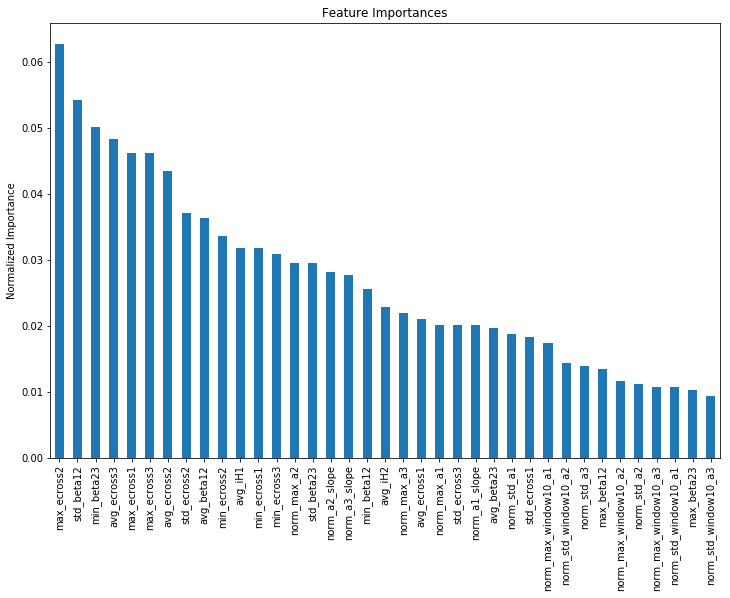

In [10]:
bst = xgb.train(params, dtrain)
feats = pd.Series(bst.get_fscore()).sort_values(ascending = False)
total_imp = np.sum(feats)
feats = feats/float(total_imp)
feats.plot(kind = "bar", title = "Feature Importances", figsize = (12, 8))
plt.ylabel("Normalized Importance")


In [15]:
data_list = pd.read_csv("../csvs/short_integration_features.csv", index_col = 0)

features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ["Lyapunov_time"]# ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 



data_list.head()

,runstring,Stable,instability_time,Rel_Eerr,t_final_short,Rel_Eerr_short,avg_a1,std_a1,max_a1,min_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0000000.bin,0.0,1.235644e+07,1.099985e-04,10000.0,1.346025e-08,1.000165,0.000329,1.001248,0.999691,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0000001.bin,0.0,1.348749e+05,1.388587e-08,10000.0,8.934681e-10,0.999952,0.000739,1.002089,0.998309,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0000002.bin,0.0,1.276381e+04,3.048261e-04,10000.0,3.169983e-08,0.998498,0.001948,1.002043,0.995446,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,0000003.bin,1.0,1.000000e+09,6.492574e-10,10000.0,6.097589e-10,1.000006,0.000026,1.000126,0.999973,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0000004.bin,0.0,8.791888e+01,9.336734e-07,10000.0,5.951220e-03,1.067267,0.030186,1.121364,1.000000,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


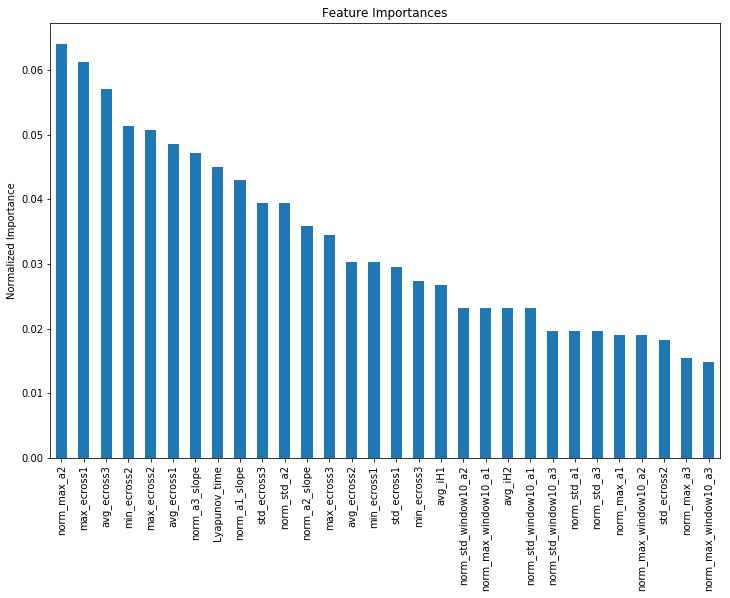

In [16]:
X = data_list[features]
Y = data_list["Stable"]

trainX, testX, trainY,testY =sklearn.model_selection.train_test_split(X, Y, random_state = 0, test_size = 0.2)
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX)
bst = xgb.train(params, dtrain)
feats = pd.Series(bst.get_fscore()).sort_values(ascending = False)
total_imp = np.sum(feats)
feats = feats/float(total_imp)
feats.plot(kind = "bar", title = "Feature Importances", figsize = (12, 8))
plt.ylabel("Normalized Importance")
